# Day 3 exercise with Sentinel-1 SAR


The purpose of this exercise is to familiarise with SAR data and enable you to download Sentine-1 SAR data, display it and create a composite SAR image. First, initialise and import the necessaries packages.

In [2]:
# -- File info -- #
__author__ = ['Andreas R. Stokholm', 'Sebastian B. Simonsen']
__copyright__ = ['A Stokholm', 'SB Simonsen']
__contact__ = ['stokholm@space.dtu.dk', 'ssim@space.dtu.dk']
__version__ = '0.2.2'
__date__ = '2025'

# -- Built-in modules -- #
import os
import sys

# -- Third-party modules -- #
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# %cd /gdrive/MyDrive/EO4Change/ex/S1 ex


## Q1, downloading the data:
First step is to download the data from the Copernicus Browser, https://browser.dataspace.copernicus.eu. Follow these steps:


1.   Click on Search
2.   Select Sentinel-1 from the "Data Sources" list
3.   Select Level-1 GRD
4.   Click "Filters", select relevant acquisition mode, typically IW for land and EW for the Arctic Ocean, see https://sentinel.esa.int/web/sentinel/copernicus/sentinel-1/acquisition-plans
5.   Select the relevant time range
6.   Draw a polygon over an interesting area (pentagon, second icon in the upper right corner)
7.   Click search
8.   Select a file from the list of a square on the map and download the file.

The file may take some minutes to download. Once the download is finished, place the file in the google drive folder that contains this script and continue with the cell below, which unzips the file.

In [5]:
def unzip_safe_file(zip_file: str):
    # -- Unzip a file in data directory. -- #
    files = os.listdir()
    if '.zip' in zip_file:
      safe_files = [file.split('.')[0] for file in files if '.SAFE' in file and not '.zip' in file]  # Find all .SAFE files.

      if zip_file.split('.')[0] not in safe_files:
        # Unzip file.
        print(f"unzipping {zip_file}")
        to_unzip = zipfile.ZipFile(zip_file, 'r')
        to_unzip.extractall()
        to_unzip.close()
        print(f"unzipped {zip_file}")
      else:
        print('file already unzipped')

    else:
      print('not a .zip file')

file_to_unzip = 'S1C_IW_GRDH_1SDV_20250608T053144_20250608T053209_002687_0058C3_2A94.SAFE.zip'
unzip_safe_file(zip_file=file_to_unzip)

unzipping S1C_IW_GRDH_1SDV_20250608T053144_20250608T053209_002687_0058C3_2A94.SAFE.zip
unzipped S1C_IW_GRDH_1SDV_20250608T053144_20250608T053209_002687_0058C3_2A94.SAFE.zip


# Q2, displaying the image:
Enter name of the downloaded and unzipped Sentinel-1 file (Do not include the file extension) and select the polarisation to visualise:

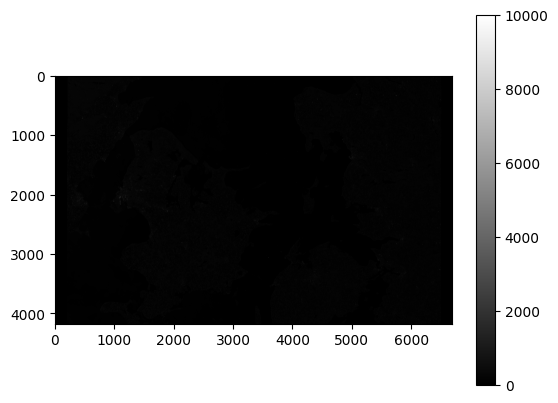

Displaying: S1C_IW_GRDH_1SDV_20250608T053144_20250608T053209_002687_0058C3_2A94


In [8]:
# -- Insert your code -- #
file = 'S1C_IW_GRDH_1SDV_20250608T053144_20250608T053209_002687_0058C3_2A94'  # example

# Read SAR file. Note that this is just one polarization.
tiff_index = 1 # Should be 1 for VV. Change to 0 for VH.

# -- End of your code -- #

cwd = os.getcwd()  # Keep track of work directory.
basedir = cwd + os.sep + file + '.SAFE' + os.sep + 'measurement'
tiff_file = os.listdir(basedir)[tiff_index]
img = plt.imread(basedir + os.sep + tiff_file)[::4, ::4]  # Read tiff file. This selects every fourth pixel to preserve RAM (otherwise it may runout in the following exercises)
s1_img = plt.figure()
plt.imshow(img, cmap='gray', vmin=0, vmax=10000)  # It is custom to display SAR images in grayscale.
plt.colorbar()
plt.show()

print(f"Displaying: {file}")


# Q3, investigating the image:
The script should run as long as the filename has been added. However, the displayed file is likely not displaying anything useful. What could be the reason for this?
Hint: look at the mean value and the maximum and/or minimum values.

In [13]:
# -- Insert your code --#
np.quantile(img, [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1])  # Display quantiles of the image.


# -- End of your code -- #

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 2.1000e+01, 3.9000e+01,
       7.9000e+01, 1.4400e+02, 2.1700e+02, 2.6200e+02, 3.7500e+02,
       6.5535e+04])

Typically the colorscale is stretched between the minimum and maximum values because of a few outliers.
We can get around this by displaying the image without outliers. This can be done using quartiles of the image.
E.g. np.quantile(a=img, q=), where q is the quantile between 0-1. Typical values are 0.5 and 0.95.
It may be useful to print the quartile values. The quartiles should be added to the plt.imshow function below.
The relevant arguments are: vmin, vmax.
https://numpy.org/doc/stable/reference/generated/numpy.quantile.html
    

In [12]:
# -- Insert your code --#
q05 = np.quantile(img, 0.05)  # 5th percentile
q95 = np.quantile(img, 0.95)  # 95th percentile



# -- End of your code -- #

Hopefully you should now see a SAR image of some place on Earth.
Is it upside down? If it is, what could be the reason for this? You can fix this by flipping the img array using np.flip(img, axis= ) (axis = 0 or 1)

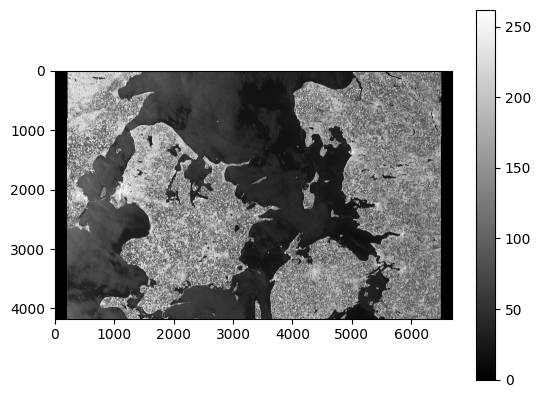

In [14]:
s1_img = plt.figure()

# -- Your code goes here -- #

plt.imshow(img, cmap='gray', vmin=q05, vmax=q95)  # It is custom to display SAR images in grayscale.

# -- End of your code -- #

plt.colorbar()
plt.show()

Find anything interesting in the image? Let's look at it tomorrow in the lecture.
Send a copy to stokholm@space.dtu.dk either by screenshotting or by saving the image with

In [15]:
s1_img.savefig('cool_s1_image.png', format='png')

# Q4, composite image:
So far we have only looked at one SAR channel, either the VV/HH or VH/HV (depending on the location of the image) but that is only half the information, and almost like only looking at the red channel of an RGB image. A common way to display multiple channels as a single image is to create a composite RGB image with the co-polarised channel as red, cross-polarised channel as green and the ratio between the co and cross-polarised channels as blue (VV / VH). Your task is to create such a composite image with your downloaded file.
Tips:


1.   Be careful when making the ratio, as you may be dividing with 0, which creates nans. These nans should be replaced by 0s.
2.   Clip the values of vv and hh using np.clip and the quantiles for each channel.
3.   Normalise the vv and vh values to be within 0-1.
4.   Create a 3D array with the shape: [X, Y, 3]


In [30]:
vv_raw = plt.imread(basedir + os.sep + os.listdir(basedir)[1])[::4, ::4]  # Read VV tiff file.
vh_raw = plt.imread(basedir + os.sep + os.listdir(basedir)[0])[::4, ::4]  # Read VH tiff file.


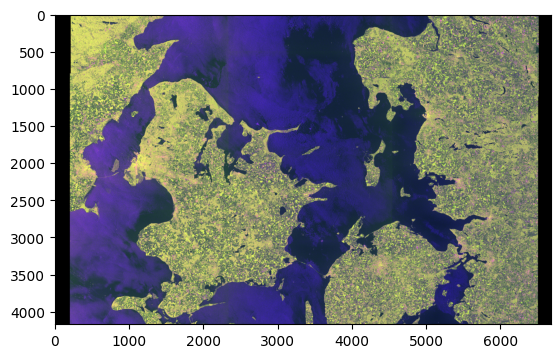

In [42]:
vv = vv_raw
vh = vh_raw

# -- Your code goes here -- #

vv = np.clip(vv, np.quantile(vv, 0.05), np.quantile(vv, 0.95))  # Clip the VV image to the 5th and 95th percentiles.
vh = np.clip(vh, np.quantile(vh, 0.05), np.quantile(vh, 0.95))  # Clip the VH image to the 5th and 95th percentiles.

ratio = np.divide(vv, vh, out=np.zeros_like(vv), where=vh != 0)


def normalize(img):
    p_low, p_high = np.percentile(img, [1, 99])
    return np.clip((img - p_low) / (p_high - p_low), 0, 1)

R = normalize(vv)
G = normalize(vh)
B = normalize(ratio)


rgb = np.stack((R, G, B), axis=-1)  # Stack the VV, VH and ratio images to create an RGB image.

# -- End of your code --#

s1_rgb_img = plt.figure()
plt.imshow(rgb)


What can you say about the image? Did new details or texture appear or becamse more pronounced compared to the grayscale image? What does the ratio beteen the co and cross-polarised channels indicate?
Let's look at it tomorrow in the lecture. Add the image to these [slides](https://docs.google.com/presentation/d/1KoxXsDaGcqR8J4NcFlGh7MBL7zII5V95/edit?usp=sharing&ouid=105485225177375608793&rtpof=true&sd=true) or send copy to stokholm@space.dtu.dk either by screenshotting or by saving the image with:

In [43]:
s1_rgb_img.savefig('cool_s1_rgbimage.png', format='png')